In [233]:
# ------------------------------
#        Changelog
# ------------------------------

## Reset workspace

In [234]:
reset -f

#### Set variables

In [235]:
# project
project = "COVID_Syria_R2"
# language
language = "en"

## Load home made functions

In [236]:
# Guidelines of using python pandas
# https://medium.com/dunder-data/minimally-sufficient-pandas-a8e67f2a2428

# %load ../data_cleaning_and_plotting_functions.py
"""This is a set of cleaning and plotting functions to speed up descriptive analyses.

These functions have been designed to work with a data set that follow GT specifications and a template
for that dataset (see the gen_templates module) These functions are intended to be loaded into an interactive
python environment such as Jupyter or Markup.

These functions were written to interact with pandas 0.18.1, numpy 1.11.1.,  matplotlib 1.5.3, and seaborn 0.7.1,
"""

__version__ = '0.2'
__author__ = 'Tomas Folke & Ulrich Utner'

# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager as font_manager
import pprint
import os as os
import math
from scipy.stats import rankdata
import statistics
from matplotlib.backends.backend_pdf import PdfPages
from datetime import datetime, date
from datetime import timedelta
import statsmodels.api as sm
import statsmodels.formula.api as smf
import math

# Set the font properties (Futura PT should be used)
font_path = 'C:/Windows/Fonts/Futura Book font.ttf'
font_prop = font_manager.FontProperties(fname=font_path) # size=12

def mismatch_search(data, template):
    """Compares the columns with a data frame to the index of a transposed matrix, and identifies columns
    that don't have a match
    """
    mismatches = []
    mismatch_numbers = []
    mismatch_number = 0
    for column in data.columns:
        if column not in template.index:
            mismatches.append(column)
            mismatch_numbers.append(mismatch_number)
        mismatch_number +=1
    print(mismatches)
    return(mismatches, mismatch_numbers)

def find_suggested_labels(mismatches, template):
    """Finds suggested labels for mismatched column names by comparing the prefix of the mismatched columns
    with the prefixes in the transposed template.
    """
    suggestion_list = []
    mismatch_prefixes = [mismatch.split('_')[0] for mismatch in mismatches]
    for label in template.index:
        if label.split('_')[0] in mismatch_prefixes:
            suggestion_list.append(label)
    return(suggestion_list)

def gen_match_dict(mismatches, suggestions):
    """Creates a dictionary from two lists, where the first list contains keys and the second contains data."""
    matching_dict = {}
    mismatches_no_partner = []
    for mismatch in mismatches:
        match = False
        for suggestion in suggestions:
                if mismatch.split('_')[0] == suggestion.split('_')[0]:
                    matching_dict[mismatch] = suggestion
                    match = True
        if match == False:
            mismatches_no_partner.append(mismatch)

    if len(mismatches) == len(matching_dict):
        return matching_dict
    else:
        return np.nan()
        print('Matching failed, the following data columns lack suggestions:')
        print(mismatches_no_partner)

def print_response_overview(data, columns):
    """Prints frequency counts for a list of columns in a data frame"""
    for column in columns:
        print(column)
        if data[column].dtype == "O":
            print(np.sort(data.loc[data[column].notna(), column].astype(str).unique()))
        else: 
            print(np.sort(data.loc[data[column].notna(), column].unique()))
        print('-----------------------------------------------------------------------------------------------------')

def count_response_proportions(data, template, columns):
    """Prints response proportions for likert scale and binary questions in a column list"""
    for column in columns:
        temp = pd.DataFrame(data.loc[:, column].value_counts(normalize=True)) * 100
        temp = temp.reset_index()
        temp.columns = column, 'percent'
        temp['percent'] = temp['percent'].round()
        temp = temp.sort_values(by=column).reset_index(drop=True)
        if template.loc[column, 'question_type'] in ['likert', 'binary']:
            print(temp)
            print('--------------------------------------------------------------------------------------------------')

def delete_dont_knows(data, columns):
    """Deletes "don't know" and "don't want to answer responses" from specified columns"""
    data.loc[:, columns] = data.loc[:, columns].replace(['6_dont_know', '3_dont_know', '7_dont_want_to_answer',
                                                          '4_dont_want_to_answer'], np.nan)

def reverse_question_scoring(data, question, include_dont_knows=False):
    """Reverses the numbers at the beginning of the response alternatives"""
    response_numbers = [np.int(answer.split('_')[0]) for answer in data[question]]
    response_numbers = np.array(response_numbers)
    if include_dont_knows == True:
        response_numbers = max(response_numbers) - response_numbers
    else:
        response_numbers = max(response_numbers) - response_numbers + 1
    response_splits = [answer.split('_') for answer in data[question]]
    updated_responses = []
    for x in range(len(response_splits)):
        updated_responses.append(np.str(response_numbers[x]) + '_' + '_'.join(response_splits[x][1:]))
    return(updated_responses)

def bin_quantities(data, template, quantiles=3):
    """Bins quantitative data"""
    for column in template.loc[template['question_type']=='quantity', :].index:
        print(column)
        extracted_quantities = []
        if data[column].dtype == str:
            for index in data.loc[data[column].notna(), :].index:
                extracted_quantities.append(np.int(data.loc[index, column].split('_')[0]))
        extracted_quantities = data.loc[data[column].notna(), column].values
        data.loc[data[column].notna(), column+'_quantiles'] = pd.qcut(extracted_quantities, quantiles)

def accurate_percentages(percentages):
    """This functions ensures that percentages for likert scale question sum up to accurate 100 %"""
    fraction = [math.modf(val) for val in percentages]
    rank = rankdata([-1*x[0] for x in fraction])
    int_sum = sum([x[1] for x in fraction])
    difference = 100-int_sum
    zeros_ones = np.zeros(len(percentages))
#     if all false pick randomly values <- to to
    if (rank <= difference).sum() < difference:
        x = np.random.choice(np.arange(1,1+len(percentages)),len(percentages), replace= False )
        zeros_ones[x <= difference] = 1
    else:
        zeros_ones[rank <= difference] = 1      
    acc_perc = np.array([x[1] for x in fraction]) + zeros_ones
    return acc_perc
 
        
def gen_summary_table(data, question):
    """Generates summary tables for a question, including frequencies percentages and cumulative frequencies"""
    table = data[question].value_counts(sort=False)
    table = pd.DataFrame(table)
    table = table.reset_index()
    table.columns = [question, 'frequency']
    table = table.sort_values(by = question).reset_index(drop=True)
    table['percent'] = (table['frequency']/table['frequency'].sum())*100
    
    if table['percent'].round().sum() == 100:
        table['percent'] = table['percent'].round()
    
    elif question in template.loc[template['question_type']=='likert', :].index:
        table['percent'] = accurate_percentages(table['percent'])

    return(table)


def language(language = 'en'):
    if language == 'en':
        mean = 'mean: '
        results = 'Results in %'
    elif language == 'fr':
        mean = 'Moyenne: '
        results = 'Résultats en %'
    return(mean, results)


def draw_basic_plot(table, likert=True, language='en', labels = 'on', path='../../output/'):
    """Generates and saves standard GT bar plots from summary tables of likert questions and binary questions."""
    sns.set(style='white')
    table2 = table.set_index(table.columns[0])
    table2 = table2.transpose()
    table2.loc['', :] = np.zeros(len(table2.columns))

    if likert == True:
        likert_dict ={1: "#c91451", 2: "#e48aa8", 3:"#d9e0d9", 4:"#81e7d1", 5: "#03cea3", 6:'#AAAAAA', 7:"#828282"}
        likert_keys = [np.int(label.split('_')[0]) for label in table2.columns]
        likert_colours = sns.color_palette([likert_dict[x] for x in likert_keys])
        colours = likert_colours
    else:
        binary_dict = {1: "#c91451", 2: "#03cea3", 3: '#AAAAAA', 4: "#828282"}
        binary_keys = [np.int(label.split('_')[0]) for label in table2.columns]
        binary_colours = sns.color_palette([binary_dict[x] for x in binary_keys])
        colours = binary_colours

    fig, ax = plt.subplots(figsize=(12, 1))
    table2.iloc[1:, :].plot(kind='barh', stacked=True, color=colours, legend=False, width=0.4, ax=ax)
    sns.despine(top=True, right=True, left=True, bottom=True)
    ax.set(xlim=(0, table2.loc['percent', :].sum()), ylim=(-0.6, 0.6), yticklabels=(), xticklabels=[])
    
    
    if labels == 'on':
        # Adding mean score and number of respondents to right top egde of the graph
        if language == 'en':
            mean = 'mean: '
            results = 'Results in %'
        elif language == 'fr':
            mean = 'Moyenne: '
            results = 'Résultats en %'

        if likert == True:
            ax.text(100, 0.35 , mean + '{0:.1f}, n={1}'.format(mean_data[table.columns[0]].mean(), table['frequency'].sum()), horizontalalignment='right', fontproperties=font_prop, size = 14)
        elif likert == False:
            ax.text(100, 0.35 , 'n={0}'.format(table['frequency'].sum() ), horizontalalignment='right', fontproperties=font_prop, size = 14)

        # Adding text 'results in %' at the right bottom of each graph
        ax.text(100, -0.51 , results, horizontalalignment='right', fontproperties=font_prop, size = 14)

    
    # Adding the percentage labels
    for p in ax.patches:
           if p.get_width() >= 1:
            ax.annotate("{0:.0f}".format(p.get_width()),
                    (p.get_x() + p.get_width()/2, p.get_y() + p.get_height()/2), xytext=(0, -6.5), textcoords='offset points',
                    weight='normal', size=18, ha='center', color="black", fontproperties=font_prop)
    question_name = table2.columns.name.split('_')[0]
    fig.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0,
             hspace = 0, wspace = 0)
    
    if column in request_dict:
        plt.savefig(path+request_dict[column]+'.pdf', dpi=600, transparent=True)
        plt.savefig(path+request_dict[column]+'.jpg', dpi=600, transparent=True)
    else:
        plt.savefig(path+question_name+'.pdf', dpi=600, transparent=True)
        plt.savefig(path+question_name+'.jpg', dpi=600, transparent=True)
    plt.close()

def gen_disag_table(data, question, breakdown):
    """Generates summary tables for disaggregated data"""
    table = data.groupby(breakdown)[question].value_counts(sort=False)
    table = pd.DataFrame(table)
    table.columns = ['frequency']
    table = table.reset_index()
    table = table.sort_values(by=[breakdown, question])
    table.reset_index(inplace=True, drop=True)
    table['percent'] = np.nan

    for category in table[breakdown].unique():
        table.loc[table[breakdown]==category, 'percent'] = table.loc[table[breakdown] == category, 'frequency']/\
                table.loc[table[breakdown]==category, 'frequency'].sum()*100
        
        if table.loc[table[breakdown]==category, 'percent'].round().sum() == 100:
            table.loc[table[breakdown]==category, 'percent'] = table.loc[table[breakdown]==category, 'percent'].round()
    
        elif question in template.loc[template['question_type']=='likert', :].index:
            table.loc[table[breakdown]==category, 'percent'] = accurate_percentages(table.loc[table[breakdown]==category, 'percent'])
    
    return table
 
def draw_disag_plot(table, likert=True, language = 'en', labels = 'on', reindex_order=np.nan, path='../../output/'):
    """Generates and saves standard GT bar plots from disaggregated tables"""

    # this formula ensures that the figure gets 2 inches wider for each category, with an additional inch for
    # the whitespaces between categories
    fig_height = len(table.loc[:, table.columns[0]].unique())
    fig, ax = plt.subplots(figsize=(12, fig_height))

    # preparing and plotting the basic graph
    table2 = table.pivot(index=table.columns[0], columns=table.columns[1], values='percent')
    if reindex_order == reindex_order:
        table2 = table2.reindex(reindex_order)
    index = list(table2.index)
    if likert == True:
        likert_dict = {1: "#c91451", 2: "#e48aa8", 3:"#d9e0d9", 4:"#81e7d1", 5:"#03cea3", 6:'#AAAAAA', 7:"#828282"}
        likert_keys = [np.int(label.split('_')[0]) for label in table2.columns]
        likert_colours = sns.color_palette([likert_dict[x] for x in likert_keys])
        colours = likert_colours
    else:
        binary_dict = {1: "#c91451", 2: "#03cea3", 3: '#AAAAAA', 4: "#828282"}
        binary_keys = [np.int(label.split('_')[0]) for label in table2.columns]
        binary_colours = sns.color_palette([binary_dict[x] for x in binary_keys])
        colours = binary_colours

    index.reverse()
    table2 = table2.reindex(index)
    table2.plot(kind='barh', stacked=True, color=colours, ax=ax, legend=False, width=0.4)

    # remove black lines around the figure
    sns.despine(top=True, right=True, left=True, bottom=True)
    alternatives = ax.get_yticklabels()
    alternatives = [alternative.get_text() for alternative in list(alternatives)]
    alternatives.reverse()

#   Adding labels to the graphs
    if labels == 'on':
        
        if language == 'en':
            mean = 'mean: '
            results = 'Results in %'
        elif language == 'fr':
            mean = 'Moyenne: '
            results = 'Résultats en %'

        # Adding mean score and number of respondents
        if likert == True:
            ax.set(xticklabels=[], ylabel='', yticklabels=[], xlim=(0, 100), ylim = (-.6, .6 + means.shape[0] -1 ))
            for i, group in enumerate(means[::-1].index):
                #if '1_' in group or '2_' in group:
                if table.columns[0] in binary_questions:
                    ax.text(0, i + .35 , group.split('_')[1].capitalize(), horizontalalignment='left', fontproperties=font_prop, size = 14)
                else:
                    ax.text(0, i + .35 , group, horizontalalignment='left', fontproperties=font_prop, size = 14)
                ax.text(100, i + .35, mean + '{0}, n={1}'.format(means.iat[len(means)-1-i,0], means.iat[len(means)-1-i,1]) , horizontalalignment='right', fontproperties=font_prop, size = 14)
            ax.text(100, -0.51 , results, horizontalalignment='right', fontproperties=font_prop, size = 14)

        if likert == False:
            ax.set(xticklabels=[], ylabel='', yticklabels=[], xlim=(0, 100), ylim = (-.6, .6 + df_freq_for_binary_q.shape[0] -1 ))
            for i, group in enumerate(df_freq_for_binary_q[::-1].index):

                #if '1_' in group or '2_' in group:
                if table.columns[0] in binary_questions: 
                    ax.text(0, i + .35 , group.split('_')[1].capitalize(), horizontalalignment='left', fontproperties=font_prop, size = 14)
                else:
                    ax.text(0, i + .35 , group, horizontalalignment='left', fontproperties=font_prop, size = 14)
                ax.text(100, i + .35, 'n={0:.0f}'.format(df_freq_for_binary_q.iat[len(df_freq_for_binary_q)-i-1,0]) , horizontalalignment='right', fontproperties=font_prop, size = 14)
            ax.text(100, -0.51 , results, horizontalalignment='right', fontproperties=font_prop, size = 14)
    
    else:
        ax.set(xticklabels=[], ylabel='', yticklabels=[], xlim=(0, 100)) 
    
    # Adding the percentage labels
    for p in ax.patches:
        if p.get_width() >= 1:
            ax.annotate("{0:.0f}".format(p.get_width()),
                    (p.get_x() + p.get_width()/2, p.get_y() + p.get_height()/2), xytext=(0, -6.5), textcoords='offset points',
                   weight='normal', size=18, ha='center', color="black", fontproperties=font_prop)
    # savefig
    question_name = table2.columns.name.split('_')[0] + '_by_' + table2.index.name.split('_')[0]

    fig.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0,
    hspace = 0, wspace = 0)

    if column in request_dict:
        plt.savefig(path + table2.index.name.split('_')[0] + '_breakdowns/' + request_dict[column] +'.pdf', dpi=600, transparent=True)
        plt.savefig(path + table2.index.name.split('_')[0] + '_breakdowns/' + request_dict[column] +'.jpg', dpi=600, transparent=True)
    else:
        plt.savefig(path + table2.index.name + '_breakdowns/' + question_name+'.pdf', dpi=600, transparent=True) # .split('_')[0]
        plt.savefig(path + table2.index.name + '_breakdowns/' + question_name+'.jpg', dpi=600, transparent=True)
    
    
    plt.close()

def remove_non_ascii(text):
    """Remove non-ascii symbols from a string"""
    return ''.join([i if ord(i) < 128 else ' ' for i in text])

def gen_long_table(data, question_lists_1):
    long_list_1 = data.loc[:, question_lists_1].copy()
    long_list_1 = pd.melt(long_list_1, value_vars=list(question_lists_1))
    freq_count = pd.DataFrame(long_list_1['value'].value_counts())
    percent_count = pd.DataFrame(long_list_1['value'].value_counts(normalize=True))
    freq_count['percent'] = percent_count['value']
    freq_count['percent'] = freq_count['percent']*100
    clean_index=[]
    for text in freq_count.index:
        clean_index.append(remove_non_ascii(text))
    freq_count.index = clean_index
    freq_count.columns = ['frequency', 'percent']
    return freq_count

def replace_response_categories(data, column, old_responses, new_response):
    """Quick way to reassign cell information inside a pandas dataframe."""
    data.loc[data[column].isin(old_responses), column] = new_response

def draw_basic_exp_plot(output, likert=True, labels = 'on', language = 'en'):
    """Generates and saves standard GT bar plots from summary tables of likert questions and binary questions.
    Gives a title to make the questions easy to identify, not meant for report writing."""
    sns.set(style='white')
#     table = gen_summary_table(data, column)
    table2 = output.set_index(output.columns[0])
    table2 = table2.transpose()
    question_name = ' '.join(table2.columns.name.split('_'))

    if likert == True:
        likert_dict ={1: "#c91451", 2: "#e48aa8", 3:"#d9e0d9", 4:"#81e7d1", 5:"#03cea3", 6:'#AAAAAA', 7:"#828282"}
        likert_keys = [np.int(label.split('_')[0]) for label in table2.columns]
        likert_colours = sns.color_palette([likert_dict[x] for x in likert_keys])
        colours = likert_colours
    else:
        binary_dict = {1: "#c91451", 2: "#03cea3", 3: '#AAAAAA', 4: "#828282"}
        binary_keys = [np.int(label.split('_')[0]) for label in table2.columns]
        binary_colours = sns.color_palette([binary_dict[x] for x in binary_keys])
        colours = binary_colours
#     fig_height = len(table.loc[:, table.columns[0]].unique())
    fig, ax = plt.subplots(figsize=(12, 1))
    pd.DataFrame(table2.iloc[1,:]).transpose().plot(kind='barh', stacked=True, color=colours, legend=False, width=.4,
                                              ax=ax, title=question_name)
    sns.despine(top=True, right=True, left=True, bottom=True)
    ax.set(xlim=(0, 100) , ylim=(-.5, .8), yticklabels=(), xticklabels=[])
    ax.text(0, .56 , question_name, horizontalalignment='left', fontproperties=font_prop, size = 12)
    if labels == 'on':
        # Adding mean score and number of respondents to right top egde of the graph
        if language == 'en':
            mean = 'mean: '
            results = 'Results in %'
        elif language == 'fr':
            mean = 'Moyenne: '
            results = 'Résultats en %'

        if likert == True:
            ax.text(100, .31 , mean + '{0:.1f}, n={1}'.format(mean_data[column].mean(),mean_data[column].count()), horizontalalignment='right', fontproperties=font_prop, size = 14) # normal size :14
        elif likert == False:
            ax.text(100, .31 , 'n={0}'.format(mean_data[column].count() ), horizontalalignment='right', fontproperties=font_prop, size = 14)

        # Adding text 'results in %' at the right bottom of each graph
        ax.text(100, -0.46 , results, horizontalalignment='right', fontproperties=font_prop, size = 14)
    
    # Adding the percentage labels
    for p in ax.patches:
        if p.get_width() >= 1:
            ax.annotate("{0:.0f}".format(p.get_width()),
                    (p.get_x() + p.get_width()/2, p.get_y() + p.get_height()/2), xytext=(0, -6.5),
                        textcoords='offset points', weight='normal', size=18, ha='center',color = 'black',  fontproperties=font_prop)
    fig.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0,
            hspace = 0, wspace = 0)

def draw_disag_exp_plot(table, likert=True, reindex_order=np.nan, labels = 'on', language = 'en'):
    """Generates and saves standard GT bar plots from disaggregated tables. Contains Question titles and
    category labels. For exploratory use, not report writing."""

    # this formula ensures that the figure gets 2 inches wider for each category, with an additional inch for
    # the whitespaces between categories
    fig_height = len(table.loc[:, table.columns[0]].unique())
    fig, ax = plt.subplots(figsize=(12, fig_height))

    # preparing and plotting the basic graph
    table2 = table.pivot(index=table.columns[0], columns=table.columns[1], values='percent')
    if reindex_order == reindex_order:
        table2 = table2.reindex(reindex_order)
    index = list(table2.index)
    if likert == True:
        likert_dict ={1: "#c91451", 2: "#e48aa8", 3:"#d9e0d9", 4:"#81e7d1", 5:"#03cea3", 6:'#AAAAAA', 7:"#828282"}
        likert_keys = [np.int(label.split('_')[0]) for label in table2.columns]
        likert_colours = sns.color_palette([likert_dict[x] for x in likert_keys])
        colours = likert_colours
    else:
        binary_dict = {1: "#c91451", 2:"#03cea3", 3: '#AAAAAA', 4: "#828282"}
        binary_keys = [np.int(label.split('_')[0]) for label in table2.columns]
        binary_colours = sns.color_palette([binary_dict[x] for x in binary_keys])
        colours = binary_colours

    index.reverse()
    table2 = table2.reindex(index)
    question_name = ' '.join(table2.columns.name.split('_'))
    table2.plot(kind='barh', stacked=True, color=colours, ax=ax, legend=False, width=0.4, title=question_name)

    # remove black lines around the figure
    sns.despine(top=True, right=True, left=True, bottom=True)
    alternatives = ax.get_yticklabels()
    alternatives = [alternative.get_text() for alternative in list(alternatives)]
    alternatives.reverse()
    ax.text(0, agg_dict[variable][column].shape[0] , variable, horizontalalignment='left', fontproperties=font_prop, size = 12)
    
    #   Adding labels to the graphs
    if labels == 'on':
        
        if language == 'en':
            mean = 'mean: '
            results = 'Results in %'
        elif language == 'fr':
            mean = 'Moyenne: '
            results = 'Résultats en %'

        # Adding mean score and number of respondents
        if likert == True:
            ax.set(xticklabels=[], ylabel='', yticklabels=[], xlim=(0, 100), ylim = (-.6, .6 + agg_dict[variable][column].shape[0]))
            for i, group in enumerate(agg_dict[variable][column][::-1].index):
                if '1_' in group or '2_' in group:
                    ax.text(0, i + .35 , group.split('_')[1].capitalize(), horizontalalignment='left', fontproperties=font_prop, size = 14)
                else:
                    ax.text(0, i + .35 , group, horizontalalignment='left', fontproperties=font_prop, size = 14)
                ax.text(100, i + .35, mean + '{0}, n={1}'.format(agg_dict[variable][column].iat[len(agg_dict[variable][column])-1-i,0], agg_dict[variable][column].iat[len(agg_dict[variable][column])-1-i,1]) , horizontalalignment='right', fontproperties=font_prop, size = 14)
            ax.text(100, -0.51 , results, horizontalalignment='right', fontproperties=font_prop, size = 14)

        if likert == False:
            ax.set(xticklabels=[], ylabel='', yticklabels=[], xlim=(0, 100), ylim = (-.6, .6 + agg_dict[variable][column].shape[0]))
            for i, group in enumerate(agg_dict[variable][column][::-1].index):

                if '1_' in group or '2_' in group:
                    ax.text(0, i + .35 , group.split('_')[1].capitalize(), horizontalalignment='left', fontproperties=font_prop, size = 14)
                else:
                    ax.text(0, i + .35 , group, horizontalalignment='left', fontproperties=font_prop, size = 14)
                ax.text(100, i + .35, 'n={0:.0f}'.format(agg_dict[variable][column].iat[len(agg_dict[variable][column])-i-1,0]) , horizontalalignment='right', fontproperties=font_prop, size = 14)
            ax.text(100, -0.51 , results, horizontalalignment='right', fontproperties=font_prop, size = 14)
    
    else:
        ax.set(xticklabels=[], ylabel='', yticklabels=[], xlim=(0, 100)) 

    # Adding the percentage labels
    for p in ax.patches:
        if p.get_width() >= 1:
            ax.annotate("{0:.0f}".format(p.get_width()),
                    (p.get_x() + p.get_width()/2, p.get_y() + p.get_height()/2), xytext=(0, -6.5), textcoords='offset points',
                   weight='normal', size=18, ha='center', color="black", fontproperties=font_prop)    
    
    fig.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)

def removing_few_dont_knows(data, columns, numbers=['6', '7'], alpha = 0.05):
    """Check if a specified response alternative has less than 5% of responses,
    if so, delete all instances of the alternative."""
    for column in columns:
        for number in numbers:
            if data.loc[(data[column].notna()) & (data[column].str.contains(number)), column].shape[0]/np.float(data[column].count()) < alpha:
                data.loc[(data[column].notna()) & (data[column].str.contains(number)), column] = np.nan

def count_answer_options(column, group):
    """In case there are multiple answers for one question, this function counts the number for each possible response option.
    The percentage is related to the sample size ."""
    
    list_answer_options = []
    for i in data[column].dropna():
        for choice in i.split(' '):
            if choice not in list_answer_options:
                list_answer_options.append(choice)
    
    
    count = {}
    gender = {keys:{'Male': 0 , 'Female': 0} for keys in list_answer_options}
    for word in list_answer_options:
        for answer in zip(data[group].dropna(), data[column].dropna()):
            if word in answer[1]:
                count.setdefault(word,0)
                count[word] +=1
                ###################
                if answer[0] == 'Male':
                    gender[word]['Male'] +=1
                elif answer[0] == 'Female':
                    gender[word]['Female'] +=1
    
    df_count = pd.DataFrame.from_dict(count, orient = 'index')
    df_count.columns = ['count']
    # Adding percentage column and label
    df_count['perc'] = df_count['count']/data.shape[0]*100
    df_count['perc'] = df_count['perc'].round(1)
    df_count.index.name = column
#     create dataframe for gender split
    df_gender = pd.DataFrame.from_dict(gender, orient = 'index')
    df_gender_perc = df_gender.apply(lambda x:x/sum(x)*100, axis = 1).round(0)
    # merging both dataframes
    df_merged = pd.merge(df_count, df_gender, left_index=True, right_index=True)
    df_merged = pd.merge(df_merged, df_gender_perc, left_index=True, right_index=True)
    
    index = [('Total count', 'count'), ('Total count', 'perc'),
         ('Absolute', 'Male_x'), ('Absolute', 'Female_x'),
         ('Percentage', 'Male_y'), ('Percentage', 'Female_y')]
    df_merged.columns = pd.MultiIndex.from_tuples(index)
    df_merged.index.name = column
    return(df_merged.sort_values(by = ('Total count', 'count'), ascending = False))

def summary_table_mpq_main(mpq_main, count_of_answers, dummy=True):
    row = 0 
    for prefix in mpq_main:
        print(prefix)
        if dummy == True:
            output = pd.DataFrame(pd.get_dummies(data[mpq_main[prefix]]).sum())
        else:
            output = pd.DataFrame(data[mpq_main[prefix]].sum())
        
        if output.shape[0] != 0:
            output['perc'] = output/count_of_answers[prefix]*100
            output['perc'] = output['perc'].round(1)
            output.rename(inplace = True, columns = {0: 'frequency'})
            output.index.name = prefix
            output.to_excel(writer, 'mpq_dd', startrow=row)
            print(output)
            row = row + output.shape[0] + 3
            print('----------')
            
def draw_time_series_plot(data, question, filename, fontsize = 6):
    fig, ax = plt.subplots(figsize=(4,2))
    sns.set(font_scale=0.8, style='white')
    
    
    transposed_data = data.transpose()
    round_means = transposed_data.loc[transposed_data[question].notna(), question]
    ax.spines['top'].set_linewidth(0.0)
    ax.spines['right'].set_linewidth(0)
    ax.spines['bottom'].set_linewidth(1.0)
    ax.spines['left'].set_linewidth(0)

    ax.tick_params(direction='out', length=4, width=0, colors='k',
               grid_color='k', grid_alpha=3, size = 7)
    #ax.axhline(linewidth=0.5, color='lightgrey', y = 3, ls = '--')
    ax.plot(transposed_data[question],
            ls = '-', color='k', lw = 0.7, marker='o', ms=3)
    

    ax.set(ylabel='', ylim=(0.5,5.5), xlabel='', xlim=(-0.3, data.shape[1]-0.7),
           #xticklabels = [names.split('. ')[0] for names in data.index],
           #xticklabels= ['July\n2018', 'October\n2018', 'April\n2019'],
           #yticks=np.arange(1, 6, 1.0)
         )

    ax.set_xticklabels(['2017', '2018', '2017'], fontproperties=font_prop, fontsize = 9)  
    ax.set_yticklabels([0,1,2,3,4,5], fontproperties=font_prop, fontsize = 9)
    
    [ax.text(p[0], p[1]+0.4, p[1], color='black', ha='center', size = fontsize, fontproperties=font_prop) for p in zip(ax.get_xticks()[-len(round_means):],
                round_means)]
    ax.xaxis.grid(False)

    fig.subplots_adjust(top = 0.9, bottom = .2, right = 0.96, left = 0.06,
                 hspace = 0, wspace = 0)
    
    plt.savefig(filename + '.pdf', dpi=600, transparent=True)
    plt.savefig(filename + '.jpg', dpi=600, transparent=True)
    plt.close()
    
            
# The following 3 functions deal with request_mcq_length DataFrame
def transform_to_list(x):
    return list(map(int, x.split(','))) if ',' in str(x) else [x]

def calculate_respondents(question, x):
    return data[question].str.split('_', expand = True)[0].astype(float).isin(x).sum()

def response_numbers(prefix):
    return(pd.notna(data[mcq_main_dict[prefix]]).any(axis = 1).sum())
# -----------------------------


def color_red_green(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    if val >= upper:
        color = '#008000' # green
    elif val <= lower:
        color = '#FF0000' # red
    else:
        color = '#000000' # black
    
    return 'color: %s' % color

def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'red' if np.absolute(val) >= 0.3 else 'black'
    return 'color: %s' % color

def quantity_cut(data, old_label, coarse_label = None, bins = False):
    """Takes a quantity columns, eg. age, number of people in a household, year (When did you leave ...)
    and cuts it in 3 equal categories"""
    
    if coarse_label == None:
        coarse_label = old_label + '_coarse'
    
    data[coarse_label] = pd.to_numeric(data[old_label], errors = 'coerce')
    data.loc[data[coarse_label] < 18, coarse_label] = np.nan
    sns.distplot(data.loc[data[coarse_label].notna(), coarse_label])
    
    if bins == True:
        age_bins = pd.IntervalIndex.from_tuples([(17, 31), (31, 42), (42, 96)], closed = 'right')
        data[coarse_label] = pd.cut(data[coarse_label], age_bins)
    else: 
        data[coarse_label] = pd.qcut(data[coarse_label], 3)
    
    CatList = [str(val) for val in sorted(data[coarse_label].dropna().unique())]
    print(CatList)

    rounded_intervals = []
    for val in [val for val in sorted(data[coarse_label].dropna().unique())]:
            rounded_intervals.append(str(int(val.left+1)) + '-' + str(int(val.right)))
    print(rounded_intervals)
    
    
    age_dict = dict(zip(CatList, rounded_intervals))
    data[coarse_label] = data[coarse_label].astype(str)
    data[coarse_label] = data[coarse_label].map(age_dict)
    data[coarse_label] = data[coarse_label].astype(pd.api.types.CategoricalDtype(categories=age_dict.values(), ordered = True))
    data[coarse_label].value_counts()
    
    demographic_columns[demographic_columns.index(old_label)] = coarse_label
    if old_label in breakdown_variables:
        breakdown_variables[breakdown_variables.index(old_label)] = coarse_label



# Template Complete Analysis

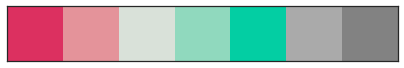

In [237]:
# NEW
likert_colours = sns.color_palette(["#DC3060", "#E4939A", "#D9E1D9", "#90D9BE", "#03CEA3", '#AAAAAA', "#828282"])
sns.palplot(likert_colours)

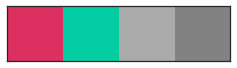

In [238]:
binary_colours = sns.color_palette(["#DC3060", "#03CEA3", '#AAAAAA', "#828282"])
sns.palplot(binary_colours)

### Loading The Data

In [239]:
os.listdir("../02_data")

['AoC for GTS.xlsx',
 'column_names.xlsx',
 'COVID_Syria_R2_clean_data.xlsx',
 'June 2020 RAW DATA_cleaning.xlsx',
 'output_graph.xlsx',
 'shortened_answers.xlsx',
 'Syria Data Cleaning Notes.docx',
 'Syria Output Request Form R2.xlsx']

In [240]:
data_path = '../02_data/June 2020 RAW DATA_cleaning.xlsx'
data = pd.read_excel(data_path)

In [241]:
template_path = '../02_data/Syria Output Request Form R2.xlsx'
template = pd.read_excel(template_path, sheet_name="Question Labels")

In [242]:
template.head()

,Column Header,Output Label,question_section,question_type,breakdown_variables,mcq_all
0,Date of Assessment,date,collection_info,date,NaN,NaN
1,Enumerator Code,enumerator_code,collection_info,text,NaN,NaN
2,Governorate,governorate,demographic_data,select_one,1.0,NaN
3,District,district,demographic_data,select_one,NaN,NaN
4,Sub-district,sub_district,demographic_data,select_one,NaN,NaN


In [243]:
request_dict = dict(zip(template['Column Header'], template['Output Label']))

In [244]:
## reindex template by output label

In [245]:
template.head()

,Column Header,Output Label,question_section,question_type,breakdown_variables,mcq_all
0,Date of Assessment,date,collection_info,date,NaN,NaN
1,Enumerator Code,enumerator_code,collection_info,text,NaN,NaN
2,Governorate,governorate,demographic_data,select_one,1.0,NaN
3,District,district,demographic_data,select_one,NaN,NaN
4,Sub-district,sub_district,demographic_data,select_one,NaN,NaN


In [246]:
## rename columns of data to match Output label
data.rename(columns = request_dict, inplace=True)

## Merge with Areas of Control file

In [247]:
data_path = '../02_data/AoC for GTS.xlsx'
AoC = pd.read_excel(data_path)

In [248]:
#keep only subdistrict name and AoC
AoC = AoC[['location_name', 'AoC']]

In [249]:
#rename AoC NSAG
AoC.loc[AoC.AoC == 'NSAG & TGF', 'AoC'] = 'NSAG'

In [250]:
AoC['AoC'].unique()

array(['GoS', 'NSAG', 'SDF'], dtype=object)

In [251]:
# merge datasets to get AoC

In [252]:
data = pd.merge(data, AoC, on = ['location_name'])

In [253]:
#add AoC to template
new_row = {'Column Header': 'AoC', 'Output Label': 'AoC', 'question_section': 'demographic_data', 'question_type': 'select_one', 'breakdown_variables': 1, 'mcq_all': "NaN"} 

In [254]:
template = template.append(new_row, ignore_index=True)

In [255]:
template.tail()

,Column Header,Output Label,question_section,question_type,breakdown_variables,mcq_all
122,"Overall, does your community believe the measu...",trust_measures_success,main_questions,binary,NaN,NaN
123,/comment,end_comments,collection_info,text,NaN,NaN
124,/end_001,end_001,collection_info,text,NaN,NaN
125,/thanks,thank_you,collection_info,text,NaN,NaN
126,AoC,AoC,demographic_data,select_one,1.0,NaN


In [256]:
template.rename(index = template['Output Label'], inplace = True)

## Create dummy variables for single choice questions and dictionary

#### Clean responses for symptoms response

In [257]:
data['symptoms_response'].value_counts()

Go to health provider    3402
Self-isolation           2515
Call health provider      649
Nothing                   237
Name: symptoms_response, dtype: int64

In [258]:
#data.loc[data["Symptoms_response"] == "Nothing left at the place of origin", 'Symptoms_response'] = "Nothing"

In [259]:
pd.set_option('display.max_rows', 20)

In [260]:
#select1 is a list of the variables we need to make into dummy variables - check and slice out any we don't want for graphs

In [261]:
select1 = list(template.loc[(template.question_section == "main_questions") & (template.question_type == 'select_one'), "Output Label"])[:3]

In [262]:
#add first economic concern here - we want breakdowns of this too
select1 = ['main_info_source', 'trusted_info_source', 'symptoms_response', '1_economic_concern']

In [263]:
dummies = pd.get_dummies(data[select1], prefix_sep = '/', )

In [264]:
data = pd.concat([data, dummies], axis = 1)

In [265]:
data.shape

(6803, 169)

In [266]:
list(data.columns)

['date',
 'enumerator_code',
 'governorate',
 'district',
 'sub_district',
 'location_type',
 'location_name',
 'p_code',
 'empty_location',
 'total_pop',
 'q_before_start',
 'introtext',
 'consent',
 'gender',
 'gender_other_specify',
 'know_age',
 'respondent_age',
 'respondent_profile',
 'respondent_profile_other_specify',
 'main_info_source',
 'main_info_source_other_specify',
 'trusted_info_source',
 'trusted_info_source_other_specify',
 'enough_info',
 'more_info_needed',
 'more_info_needed/nothing',
 'more_info_needed/symptoms',
 'more_info_needed/sickness',
 'more_info_needed/access_health',
 'more_info_needed/reliable_info',
 'more_info_needed/other_aid',
 'more_info_needed/cases',
 'more_info_needed/testing',
 'more_info_needed/treatment',
 'more_info_needed/other',
 'more_info_needed/dkn',
 'more_info_needed/dwn',
 'more_info_needed_other_specify',
 'measures_adopted',
 'measures_adopted/none',
 'measures_adopted/handwash',
 'measures_adopted/distance',
 'measures_adopted/vu

#### Make dictionary for Single Choice Questions

In [267]:
scq_main_keys = select1

In [268]:
scq_main_keys

['main_info_source',
 'trusted_info_source',
 'symptoms_response',
 '1_economic_concern']

In [269]:
scq_main_values = []
for key in scq_main_keys:
    print(key)
    for col in data:
        if col.startswith(key + '/'):
            scq_main_values.append(col)   
    

main_info_source
trusted_info_source
symptoms_response
1_economic_concern


In [270]:
scq_main_values

['main_info_source/Community groups (formal)',
 'main_info_source/Community leaders',
 'main_info_source/Employer',
 'main_info_source/Health professionals/providers',
 'main_info_source/Local government',
 'main_info_source/National government',
 'main_info_source/News media',
 'main_info_source/None - do not trust any of the information received',
 'main_info_source/Religious groups',
 'main_info_source/Social media',
 'main_info_source/UN/NGOs',
 'main_info_source/Word of mouth - family/friends',
 'trusted_info_source/Community groups (formal)',
 'trusted_info_source/Community leaders',
 "trusted_info_source/Don't know",
 "trusted_info_source/Don't want to answer",
 'trusted_info_source/Employer',
 'trusted_info_source/Health professionals/providers',
 'trusted_info_source/Local government',
 'trusted_info_source/National government',
 'trusted_info_source/News media',
 'trusted_info_source/None - do not trust any of the information received',
 'trusted_info_source/Religious groups'

In [271]:
scq_main_dict = {key:[] for key in scq_main_keys}


In [272]:
for key in scq_main_dict:
    print(key)
    for value in scq_main_values:
        if key == value:
            pass
        else:
            if key in value:
                scq_main_dict[key].append(value)

main_info_source
trusted_info_source
symptoms_response
1_economic_concern


In [273]:
scq_main_dict

{'main_info_source': ['main_info_source/Community groups (formal)',
  'main_info_source/Community leaders',
  'main_info_source/Employer',
  'main_info_source/Health professionals/providers',
  'main_info_source/Local government',
  'main_info_source/National government',
  'main_info_source/News media',
  'main_info_source/None - do not trust any of the information received',
  'main_info_source/Religious groups',
  'main_info_source/Social media',
  'main_info_source/UN/NGOs',
  'main_info_source/Word of mouth - family/friends'],
 'trusted_info_source': ['trusted_info_source/Community groups (formal)',
  'trusted_info_source/Community leaders',
  "trusted_info_source/Don't know",
  "trusted_info_source/Don't want to answer",
  'trusted_info_source/Employer',
  'trusted_info_source/Health professionals/providers',
  'trusted_info_source/Local government',
  'trusted_info_source/National government',
  'trusted_info_source/News media',
  'trusted_info_source/None - do not trust any of 

### Remove empty rows, define question groups

In [274]:
data.shape

(6803, 169)

In [275]:
#data = data.dropna(how='all', axis=0)

In [276]:
demographic_columns = list(template.loc[template['question_section'].isin(['demograpic_data', 'demographic_data']), "Output Label"])
collection_columns = list(template.loc[template['question_section']=='collection_info', "Output Label"])
question_columns = list(template.loc[(template['question_section']=='main_questions') & (template['question_type'] !='select_multiple') , "Output Label"])
question_columns = [x for x in question_columns if x not in select1]


template_questions = template.loc[template['Output Label'].isin(question_columns), :]
breakdown_columns = template_questions.loc[template_questions['question_type'].isin(['binary', 'likert']), "Output Label"].values
mean_columns = list(template_questions.loc[template_questions['question_type'].isin(['likert']), "Output Label"])

binary_questions = list(template.loc[(template.question_section == 'main_questions') & (template.question_type == 'binary'), "Output Label"])
likert_questions = list(template.loc[(template.question_section == 'main_questions') & (template.question_type == 'likert'), "Output Label"])
breakdown_variables = list(template.loc[template.breakdown_variables == True, "Output Label"])

#mcq_dd = list(template.loc[(template.question_section == 'demographic_data') & (template.question_type == 'multiple_choice'), "Output Label"])
mcq_main_keys = list(template.loc[(template.mcq_all == True) & (template.question_type == 'select_multiple'), "Output Label"])
mcq_main_values = list(template.loc[(template.question_section == "main_questions") & ((template.question_type == 'select_multiple')), "Output Label"])

In [277]:
question_columns


['main_info_source_other_specify',
 'trusted_info_source_other_specify',
 'enough_info',
 'more_info_needed_other_specify',
 'measures_adopted_other_specify',
 'most_important_measures_other_specify',
 'most_difficult_measures_other_specify',
 'why_difficult_other_specify',
 'symptoms_response_other_specify',
 'change_basic_needs',
 'change_basic_needs_other_specify',
 'reasons_needs_worsened_other_specify',
 '1_economic_concern_other_specify',
 '2_economic_concern',
 '2_economic_concern_other_specify',
 '3_economic_concern',
 '3_economic_concern_other_specify',
 'trust_measures_success']

In [278]:
mcq_main_keys

['more_info_needed',
 'measures_adopted',
 'most_important_measures',
 'most_difficult_measures',
 'why_difficult',
 'reasons_needs_worsened']

In [279]:
mcq_main_values

['more_info_needed',
 'more_info_needed/nothing',
 'more_info_needed/symptoms',
 'more_info_needed/sickness',
 'more_info_needed/access_health',
 'more_info_needed/reliable_info',
 'more_info_needed/other_aid',
 'more_info_needed/cases',
 'more_info_needed/testing',
 'more_info_needed/treatment',
 'more_info_needed/other',
 'more_info_needed/dkn',
 'more_info_needed/dwn',
 'measures_adopted',
 'measures_adopted/none',
 'measures_adopted/handwash',
 'measures_adopted/distance',
 'measures_adopted/vuln_iso',
 'measures_adopted/stayhome',
 'measures_adopted/stayhome_except',
 'measures_adopted/facemask',
 'measures_adopted/gloves',
 'measures_adopted/no_travel',
 'measures_adopted/financial_support',
 'measures_adopted/hygiene_materials',
 'measures_adopted/personal_health',
 'measures_adopted/close_borders',
 'measures_adopted/dkn',
 'measures_adopted/other',
 'measures_adopted/dwn',
 'most_important_measures',
 'most_important_measures/none',
 'most_important_measures/handwash',
 'most_

In [280]:
mcq_main_dict = {key:[] for key in mcq_main_keys}

In [281]:
mcq_main_dict

{'more_info_needed': [],
 'measures_adopted': [],
 'most_important_measures': [],
 'most_difficult_measures': [],
 'why_difficult': [],
 'reasons_needs_worsened': []}

In [282]:
for key in mcq_main_dict:
    print(key)
    for value in mcq_main_values:
        if key == value:
            pass
        else:
            if key in value:
                mcq_main_dict[key].append(value)

more_info_needed
measures_adopted
most_important_measures
most_difficult_measures
why_difficult
reasons_needs_worsened


#### Merge mcq_dict and scq_dict

In [283]:
mcq_main_dict = {**mcq_main_dict, **scq_main_dict}

In [284]:
mcq_main_dict

{'more_info_needed': ['more_info_needed/nothing',
  'more_info_needed/symptoms',
  'more_info_needed/sickness',
  'more_info_needed/access_health',
  'more_info_needed/reliable_info',
  'more_info_needed/other_aid',
  'more_info_needed/cases',
  'more_info_needed/testing',
  'more_info_needed/treatment',
  'more_info_needed/other',
  'more_info_needed/dkn',
  'more_info_needed/dwn'],
 'measures_adopted': ['measures_adopted/none',
  'measures_adopted/handwash',
  'measures_adopted/distance',
  'measures_adopted/vuln_iso',
  'measures_adopted/stayhome',
  'measures_adopted/stayhome_except',
  'measures_adopted/facemask',
  'measures_adopted/gloves',
  'measures_adopted/no_travel',
  'measures_adopted/financial_support',
  'measures_adopted/hygiene_materials',
  'measures_adopted/personal_health',
  'measures_adopted/close_borders',
  'measures_adopted/dkn',
  'measures_adopted/other',
  'measures_adopted/dwn'],
 'most_important_measures': ['most_important_measures/none',
  'most_importan

# Demograhic Questions

#### Removing empty columns from the demographic column list

In [285]:
for column in demographic_columns:
    if data[column].count() == 0:
        print(column)
        demographic_columns.remove(column)

gender_other_specify


In [286]:
demographic_columns

['governorate',
 'district',
 'sub_district',
 'location_type',
 'location_name',
 'p_code',
 'empty_location',
 'total_pop',
 'q_before_start',
 'consent',
 'gender',
 'know_age',
 'respondent_age',
 'respondent_profile',
 'respondent_profile_other_specify',
 'AoC']

In [287]:
#data.replace('---', np.nan, inplace = True)

In [288]:
# Governate

In [289]:
data['governorate'].value_counts()

Aleppo            1635
Al-Hasakeh        1193
Idleb              613
Ar-Raqqa           604
Hama               525
Homs               471
Tartous            470
Lattakia           377
Rural Damascus     236
Deir-ez-Zor        192
Dar'a              187
As-Sweida          144
Damascus            94
Quneitra            62
Name: governorate, dtype: int64

In [290]:
data['consent'].value_counts()

Yes    6803
Name: consent, dtype: int64

In [291]:
data.loc[data['consent'] == "No", :] = np.nan

In [292]:
data.dropna(how='all', axis=0, inplace=True)

In [293]:
data['empty_location'].value_counts()

No    6803
Name: empty_location, dtype: int64

In [294]:
# Remove empty location = yes
data.loc[data['empty_location'] == "Yes", :] = np.nan

In [295]:
data.dropna(how='all', axis=0, inplace=True)

In [296]:
# Location name
data['location_type'].value_counts()

Community       6129
Neighborhood     390
Camp             284
Name: location_type, dtype: int64

In [297]:
#data.loc[data["location_type"] == "Neighborhood", 'location_type'] = "Urban"
#data.loc[data["location_type"] == "Community", 'location_type'] = "Rural"

In [298]:
#data['location_type'].value_counts()

In [299]:
data['gender'].value_counts()

Female    3586
Male      3217
Name: gender, dtype: int64

In [300]:
data['respondent_profile'] = data['respondent_profile'].str.strip()

In [301]:
data['respondent_profile'].value_counts()

Community leader           1415
Teacher                    1356
Health worker              1270
Local administration        889
Trader/shopkeeper           621
Social worker               397
IDP group leader            374
Humanitarian aid worker     134
CBO leader                  103
Returnee group leader        75
Religious leader             69
Journalist                   69
Other - please specify       31
Name: respondent_profile, dtype: int64

In [302]:
data['respondent_profile_other_specify'].value_counts()

IDP group leader           11
Housewife                   9
Returnee group leader       9
Farmer                      7
Humanitarian aid worker     5
Cattleman                   4
Fisherman                   3
Mechanic                    2
Student                     1
Driver                      1
Seamstress                  1
Dentist                     1
Engineer                    1
Dealer                      1
Cleaner                     1
Name: respondent_profile_other_specify, dtype: int64

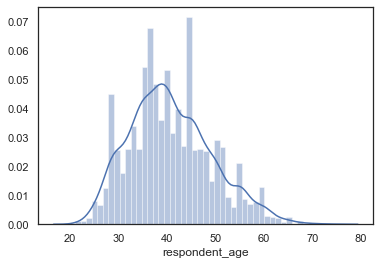

In [303]:
## Age
data['respondent_age'].value_counts()
sns.distplot(data.loc[data['respondent_age'].notna(), 'respondent_age'])

In [304]:
data['age_coarse'] = np.nan

In [305]:
data.loc[data['respondent_age'] <= 30, 'age_coarse'] = "18-30"
data.loc[data['respondent_age'].between(31,45), 'age_coarse'] = "31-45"
data.loc[data['respondent_age'].between(46,60), 'age_coarse'] = "46-60"
data.loc[data['respondent_age'] > 60, 'age_coarse'] = "60+"

In [306]:
data['age_coarse'].value_counts()

31-45    4141
46-60    1704
18-30     792
60+       104
Name: age_coarse, dtype: int64

In [307]:
data["age_coarse"] = data["age_coarse"].astype(pd.api.types.CategoricalDtype(categories=["18-30", "31-45", "46-60", "60+"], ordered = True))
data["age_coarse"].value_counts()
    
demographic_columns[demographic_columns.index("respondent_age")] = "age_coarse"
if "respondent_age" in breakdown_variables:
    breakdown_variables[breakdown_variables.index("respondent_age")] = "age_coarse"


In [308]:
data['age_coarse'].value_counts().sort_index()

18-30     792
31-45    4141
46-60    1704
60+       104
Name: age_coarse, dtype: int64

# Binary Questions

### Determine proportion of don't knows and delete them from binary questions

In [309]:
binary_questions

['enough_info', 'trust_measures_success']

In [310]:
count_response_proportions(data, template, binary_questions)

  enough_info  percent
0  Don't know      0.0
1          No     48.0
2         Yes     52.0
--------------------------------------------------------------------------------------------------
  trust_measures_success  percent
0             Don't know      1.0
1                     No     36.0
2                    Yes     63.0
--------------------------------------------------------------------------------------------------


In [311]:
for q in binary_questions:
    print(q)
    data[q] = data[q].map({'No':'1_No', 'Yes': '2_Yes'})

enough_info
trust_measures_success


In [312]:
count_response_proportions(data, template, binary_questions)

  enough_info  percent
0        1_No     48.0
1       2_Yes     52.0
--------------------------------------------------------------------------------------------------
  trust_measures_success  percent
0                   1_No     36.0
1                  2_Yes     64.0
--------------------------------------------------------------------------------------------------


# Multiple choice questions

#### Create response count - how many people answered each question

In [313]:
mcq_main_dict.keys()

dict_keys(['more_info_needed', 'measures_adopted', 'most_important_measures', 'most_difficult_measures', 'why_difficult', 'reasons_needs_worsened', 'main_info_source', 'trusted_info_source', 'symptoms_response', '1_economic_concern'])

In [314]:
resp_number = {key:np.nan for key in mcq_main_dict.keys()}

In [315]:
resp_number

{'more_info_needed': nan,
 'measures_adopted': nan,
 'most_important_measures': nan,
 'most_difficult_measures': nan,
 'why_difficult': nan,
 'reasons_needs_worsened': nan,
 'main_info_source': nan,
 'trusted_info_source': nan,
 'symptoms_response': nan,
 '1_economic_concern': nan}

In [316]:
for key in resp_number:
    print(key)
    resp_number[key] = data[key].notna().sum()

more_info_needed
measures_adopted
most_important_measures
most_difficult_measures
why_difficult
reasons_needs_worsened
main_info_source
trusted_info_source
symptoms_response
1_economic_concern


In [317]:
resp_number

{'more_info_needed': 6803,
 'measures_adopted': 6803,
 'most_important_measures': 6803,
 'most_difficult_measures': 6803,
 'why_difficult': 6157,
 'reasons_needs_worsened': 5751,
 'main_info_source': 6803,
 'trusted_info_source': 6803,
 'symptoms_response': 6803,
 '1_economic_concern': 6803}

## Cleaning responses

In [318]:
data['change_basic_needs'].value_counts()

Worsened                  5751
No change                  986
Improved                    64
Other - please specify       1
Don't want to answer         1
Name: change_basic_needs, dtype: int64

In [319]:
data.loc[data["change_basic_needs"].isin(["Other - please specify", "Don't want to answer"]), 'change_basic_needs'] = np.nan

In [320]:
data.loc[data['change_basic_needs'] == "Worsened", "change_basic_needs"] = "1_Worsened"
data.loc[data['change_basic_needs'] == "No change", "change_basic_needs"] = "3_No change"
data.loc[data['change_basic_needs'] == "Improved", "change_basic_needs"] = "5_Improved"

In [321]:
mean_data = data.copy()
for column in mean_columns:
    print(column)
    mean_data.loc[mean_data[column].notna(), column] = mean_data.loc[mean_data[column].notna(), column].str.split('_', expand=True)[0]
    mean_data.loc[: , column] = mean_data.loc[: , column].astype(float)
    mean_data.loc[mean_data[column]>5, column] = np.nan
mean_data.loc[0:10, mean_columns]

change_basic_needs


,change_basic_needs
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0
9,1.0


# Creating the excel spreadsheet and plotting the graphs

In [322]:
output_path = r'../03_output' 
if not os.path.exists(output_path):
    os.makedirs(output_path)
output_path = output_path + '/'

In [323]:
data.to_excel('../02_data/' + project + '_clean_data.xlsx', index=False)

In [324]:
writer = pd.ExcelWriter(output_path + project + '.xlsx', engine = 'xlsxwriter')

In [325]:
demographic_columns

['governorate',
 'district',
 'sub_district',
 'location_type',
 'location_name',
 'p_code',
 'empty_location',
 'total_pop',
 'q_before_start',
 'consent',
 'gender',
 'know_age',
 'age_coarse',
 'respondent_profile',
 'respondent_profile_other_specify',
 'AoC']

In [326]:
demographic_columns = ['governorate',
 'district',
 'sub_district',
 'location_type',
 #'location_name',
 #'p_code',
 #'empty_location',
 #'total_pop',
 #'q_before_start',
 #'consent',
 'gender',
 #'know_age',
 'age_coarse',
 'respondent_profile',
 'respondent_profile_other_specify',
 'AoC']

In [327]:
row = 0
for column in demographic_columns:
    print(column)
    print(row)

### Dealing with quantities
    output = gen_summary_table(data, column)
    
    for i in output.index:
        if type(output.iloc[i, 0]) == str:
            output.iloc[i, 0] = remove_non_ascii(output.iloc[i, 0])
    output.to_excel(writer, 'demographics', startrow=row)
    print(output)
    row = row + output.shape[0] + 2
    print('--------------------------------------------------------------------------------------------------')

governorate
0
       governorate  frequency    percent
0       Al-Hasakeh       1193  17.536381
1           Aleppo       1635  24.033515
2         Ar-Raqqa        604   8.878436
3        As-Sweida        144   2.116713
4         Damascus         94   1.381743
5            Dar'a        187   2.748787
6      Deir-ez-Zor        192   2.822284
7             Hama        525   7.717184
8             Homs        471   6.923416
9            Idleb        613   9.010731
10        Lattakia        377   5.541673
11        Quneitra         62   0.911363
12  Rural Damascus        236   3.469058
13         Tartous        470   6.908717
--------------------------------------------------------------------------------------------------
district
16
       district  frequency   percent
0         A'zaz        137  2.013817
1     Abu Kamal         39  0.573276
2         Afrin        254  3.733647
3   Ain Al Arab        322  4.733206
4        Al Bab        228  3.351463
..          ...        ...       ...
5

## MCQ - Breakdowns

In [328]:
mcq_main_dict.keys()

dict_keys(['more_info_needed', 'measures_adopted', 'most_important_measures', 'most_difficult_measures', 'why_difficult', 'reasons_needs_worsened', 'main_info_source', 'trusted_info_source', 'symptoms_response', '1_economic_concern'])

In [329]:
resp_number

{'more_info_needed': 6803,
 'measures_adopted': 6803,
 'most_important_measures': 6803,
 'most_difficult_measures': 6803,
 'why_difficult': 6157,
 'reasons_needs_worsened': 5751,
 'main_info_source': 6803,
 'trusted_info_source': 6803,
 'symptoms_response': 6803,
 '1_economic_concern': 6803}

In [330]:
row = 0
for prefix in mcq_main_dict:
    print(prefix)
    output_dd = pd.DataFrame(data[mcq_main_dict[prefix]].sum()).sort_values(by = 0 , ascending=False)
    output_dd['perc'] = output_dd/resp_number[prefix]*100
    
    output_dd['perc'] = output_dd['perc'].round(1)
    output_dd.rename(inplace = True, columns = {0: 'frequency'})
    output_dd.index.name = prefix
    output_dd.to_excel(writer, 'mpq_main', startrow=row)
    row = row + output_dd.shape[0] + 2
    print(output_dd)

more_info_needed
                                frequency  perc
more_info_needed                               
more_info_needed/sickness          3669.0  53.9
more_info_needed/treatment         3588.0  52.7
more_info_needed/testing           2900.0  42.6
more_info_needed/symptoms          2584.0  38.0
more_info_needed/access_health     2398.0  35.2
more_info_needed/other_aid         2073.0  30.5
more_info_needed/reliable_info     1940.0  28.5
more_info_needed/cases             1878.0  27.6
more_info_needed/other              962.0  14.1
more_info_needed/nothing            723.0  10.6
more_info_needed/dkn                  5.0   0.1
more_info_needed/dwn                  1.0   0.0
measures_adopted
                                    frequency  perc
measures_adopted                                   
measures_adopted/handwash              5081.0  74.7
measures_adopted/distance              1692.0  24.9
measures_adopted/vuln_iso              1415.0  20.8
measures_adopted/none             

In [331]:
gender_freq = {}
for key in resp_number:
    print(key)
    gender_freq[key] = data.groupby("gender")[key].count().to_dict()
gender_freq

more_info_needed
measures_adopted
most_important_measures
most_difficult_measures
why_difficult
reasons_needs_worsened
main_info_source
trusted_info_source
symptoms_response
1_economic_concern


{'more_info_needed': {'Female': 3586, 'Male': 3217},
 'measures_adopted': {'Female': 3586, 'Male': 3217},
 'most_important_measures': {'Female': 3586, 'Male': 3217},
 'most_difficult_measures': {'Female': 3586, 'Male': 3217},
 'why_difficult': {'Female': 3301, 'Male': 2856},
 'reasons_needs_worsened': {'Female': 3238, 'Male': 2513},
 'main_info_source': {'Female': 3586, 'Male': 3217},
 'trusted_info_source': {'Female': 3586, 'Male': 3217},
 'symptoms_response': {'Female': 3586, 'Male': 3217},
 '1_economic_concern': {'Female': 3586, 'Male': 3217}}

In [332]:
row = 0
for key in mcq_main_dict:
    output = pd.DataFrame(data.groupby('gender')[mcq_main_dict[key]].sum().transpose())
    cols = output.columns
    output = pd.concat([output, (output.divide(list(gender_freq[key].values()), axis = 'columns')*100).round(2)], axis = 1)
    output.index.name = key
    output.columns = pd.MultiIndex.from_product([['Absolute', 'Percentage'], cols])
    
    output.to_excel(writer, 'mpq_main_Gender_split', startrow = row)
    row = row + output.shape[0] + 3
    print(output)

                               Absolute         Percentage       
gender                           Female    Male     Female   Male
more_info_needed                                                 
more_info_needed/nothing          344.0   379.0       9.59  11.78
more_info_needed/symptoms        1299.0  1285.0      36.22  39.94
more_info_needed/sickness        1820.0  1849.0      50.75  57.48
more_info_needed/access_health   1287.0  1111.0      35.89  34.54
more_info_needed/reliable_info   1091.0   849.0      30.42  26.39
more_info_needed/other_aid       1094.0   979.0      30.51  30.43
more_info_needed/cases           1111.0   767.0      30.98  23.84
more_info_needed/testing         1626.0  1274.0      45.34  39.60
more_info_needed/treatment       2002.0  1586.0      55.83  49.30
more_info_needed/other            482.0   480.0      13.44  14.92
more_info_needed/dkn                2.0     3.0       0.06   0.09
more_info_needed/dwn                1.0     0.0       0.03   0.00
          

In [333]:
AoC_freq = {}
for key in resp_number:
    print(key)
    AoC_freq[key] = data.groupby("AoC")[key].count().to_dict()
AoC_freq

more_info_needed
measures_adopted
most_important_measures
most_difficult_measures
why_difficult
reasons_needs_worsened
main_info_source
trusted_info_source
symptoms_response
1_economic_concern


{'more_info_needed': {'GoS': 3356, 'NSAG': 1382, 'SDF': 2065},
 'measures_adopted': {'GoS': 3356, 'NSAG': 1382, 'SDF': 2065},
 'most_important_measures': {'GoS': 3356, 'NSAG': 1382, 'SDF': 2065},
 'most_difficult_measures': {'GoS': 3356, 'NSAG': 1382, 'SDF': 2065},
 'why_difficult': {'GoS': 3156, 'NSAG': 1282, 'SDF': 1719},
 'reasons_needs_worsened': {'GoS': 3218, 'NSAG': 499, 'SDF': 2034},
 'main_info_source': {'GoS': 3356, 'NSAG': 1382, 'SDF': 2065},
 'trusted_info_source': {'GoS': 3356, 'NSAG': 1382, 'SDF': 2065},
 'symptoms_response': {'GoS': 3356, 'NSAG': 1382, 'SDF': 2065},
 '1_economic_concern': {'GoS': 3356, 'NSAG': 1382, 'SDF': 2065}}

In [334]:
row = 0
for key in mcq_main_dict:
    output = pd.DataFrame(data.groupby('AoC')[mcq_main_dict[key]].sum().transpose())
    cols = output.columns
    output = pd.concat([output, (output.divide(list(AoC_freq[key].values()), axis = 'columns')*100).round(2)], axis = 1)
    output.index.name = key
    output.columns = pd.MultiIndex.from_product([['Absolute', 'Percentage'], cols])
    
    output.to_excel(writer, 'mcq_main_AoC_split', startrow = row)
    row = row + output.shape[0] + 3
    print(output)

                               Absolute                Percentage         \
AoC                                 GoS   NSAG     SDF        GoS   NSAG   
more_info_needed                                                           
more_info_needed/nothing          209.0  115.0   399.0       6.23   8.32   
more_info_needed/symptoms        1512.0  478.0   594.0      45.05  34.59   
more_info_needed/sickness        1869.0  818.0   982.0      55.69  59.19   
more_info_needed/access_health   1258.0  525.0   615.0      37.49  37.99   
more_info_needed/reliable_info    948.0  227.0   765.0      28.25  16.43   
more_info_needed/other_aid       1501.0  289.0   283.0      44.73  20.91   
more_info_needed/cases           1006.0  247.0   625.0      29.98  17.87   
more_info_needed/testing         1167.0  741.0   992.0      34.77  53.62   
more_info_needed/treatment       1462.0  838.0  1288.0      43.56  60.64   
more_info_needed/other            528.0  239.0   195.0      15.73  17.29   
more_info_ne

In [335]:
gov_freq = {}
for key in resp_number:
    print(key)
    gov_freq[key] = data.groupby("governorate")[key].count().to_dict()
gov_freq

more_info_needed
measures_adopted
most_important_measures
most_difficult_measures
why_difficult
reasons_needs_worsened
main_info_source
trusted_info_source
symptoms_response
1_economic_concern


{'more_info_needed': {'Al-Hasakeh': 1193,
  'Aleppo': 1635,
  'Ar-Raqqa': 604,
  'As-Sweida': 144,
  'Damascus': 94,
  "Dar'a": 187,
  'Deir-ez-Zor': 192,
  'Hama': 525,
  'Homs': 471,
  'Idleb': 613,
  'Lattakia': 377,
  'Quneitra': 62,
  'Rural Damascus': 236,
  'Tartous': 470},
 'measures_adopted': {'Al-Hasakeh': 1193,
  'Aleppo': 1635,
  'Ar-Raqqa': 604,
  'As-Sweida': 144,
  'Damascus': 94,
  "Dar'a": 187,
  'Deir-ez-Zor': 192,
  'Hama': 525,
  'Homs': 471,
  'Idleb': 613,
  'Lattakia': 377,
  'Quneitra': 62,
  'Rural Damascus': 236,
  'Tartous': 470},
 'most_important_measures': {'Al-Hasakeh': 1193,
  'Aleppo': 1635,
  'Ar-Raqqa': 604,
  'As-Sweida': 144,
  'Damascus': 94,
  "Dar'a": 187,
  'Deir-ez-Zor': 192,
  'Hama': 525,
  'Homs': 471,
  'Idleb': 613,
  'Lattakia': 377,
  'Quneitra': 62,
  'Rural Damascus': 236,
  'Tartous': 470},
 'most_difficult_measures': {'Al-Hasakeh': 1193,
  'Aleppo': 1635,
  'Ar-Raqqa': 604,
  'As-Sweida': 144,
  'Damascus': 94,
  "Dar'a": 187,
  'Deir

In [336]:
row = 0
for key in mcq_main_dict:
    output = pd.DataFrame(data.groupby('governorate')[mcq_main_dict[key]].sum().transpose())
    cols = output.columns
    output = pd.concat([output, (output.divide(list(gov_freq[key].values()), axis = 'columns')*100).round(2)], axis = 1)
    output.index.name = key
    output.columns = pd.MultiIndex.from_product([['Absolute', 'Percentage'], cols])
    
    output.to_excel(writer, 'mpq_main_Governorate_split', startrow = row)
    row = row + output.shape[0] + 3
    print(output)

                                 Absolute                                     \
governorate                    Al-Hasakeh Aleppo Ar-Raqqa As-Sweida Damascus   
more_info_needed                                                               
more_info_needed/nothing             25.0  385.0     90.0       0.0     16.0   
more_info_needed/symptoms           349.0  694.0    181.0      68.0     33.0   
more_info_needed/sickness           544.0  951.0    381.0      38.0     57.0   
more_info_needed/access_health      409.0  520.0    259.0      39.0     39.0   
more_info_needed/reliable_info      507.0  311.0    107.0      62.0     42.0   
more_info_needed/other_aid          174.0  165.0    155.0      92.0     49.0   
more_info_needed/cases              552.0  268.0     50.0      67.0     41.0   
more_info_needed/testing            734.0  522.0    383.0     120.0     36.0   
more_info_needed/treatment          962.0  561.0    387.0       4.0     56.0   
more_info_needed/other               63.

### Summary tables for all main questions

In [337]:
means = pd.DataFrame(mean_data[mean_columns].mean())
means.columns = ['mean']
means = means.round(1)

In [338]:
try: request_dict
except NameError: request_dict = {}

In [339]:
#prefix_col = dict(zip([col for col in list(request_dict.values())], list(request_dict.values())) )

In [340]:
question_columns

['main_info_source_other_specify',
 'trusted_info_source_other_specify',
 'enough_info',
 'more_info_needed_other_specify',
 'measures_adopted_other_specify',
 'most_important_measures_other_specify',
 'most_difficult_measures_other_specify',
 'why_difficult_other_specify',
 'symptoms_response_other_specify',
 'change_basic_needs',
 'change_basic_needs_other_specify',
 'reasons_needs_worsened_other_specify',
 '1_economic_concern_other_specify',
 '2_economic_concern',
 '2_economic_concern_other_specify',
 '3_economic_concern',
 '3_economic_concern_other_specify',
 'trust_measures_success']

In [341]:
row = 0
written_rows = {}
for column in question_columns:
    print(column)
    tab = column
    if len(tab) >= 31:
        tab = tab[0:31]
    
    if column in template.loc[(template['question_section'] == 'main_questions') & (template['question_type'] == 'open'), ].index:
        data[column] = data[column].astype(str)
    if len(data[column].value_counts()) != 0:
        output = gen_summary_table(data, column)

        if column in template.loc[template['question_type']=='likert', :].index:
            likert_question = True
            draw_basic_plot(output, likert_question, path=output_path, language = 'en', labels = 'on')    
        elif column in template.loc[template['question_type']=='binary', :].index:
            likert_question = False
            draw_basic_plot(output, likert_question, path=output_path, language = 'en', labels = 'on')
 
        ### clearing out non-ascii characters
        for i in output.index:
            if type(output.iloc[i, 0]) == str:
                output.iloc[i, 0] = remove_non_ascii(output.iloc[i, 0])
        written_rows[column] = output.shape[0] + 2
        output.to_excel(writer, tab, startrow=row)
        
        if column in template.loc[template['question_type']=='likert', :].index:
            mean_freq = pd.DataFrame.from_dict({'mean': round(mean_data[column].mean(),1), 'frequeny': output['frequency'].sum()}, orient = 'index').transpose()
            mean_freq.to_excel(writer, tab, startcol = 20, startrow = row)
            
            workbook  = writer.book
            worksheet = writer.sheets[tab]

            #if mean_freq.iloc[0,0] >= upper:
            #    color = '#008000' # green
            #elif mean_freq.iloc[0,0] <= lower:
            #    color = '#FF0000' # red
            #else:
            #    color = '#FFFFFF' # white
           
             # Add a header format
            #header_format = workbook.add_format({'bold': True,
            #     'align': 'center',
            #     'fg_color': color,
            #     'border': 1})
            #for col_num, value in enumerate(mean_freq.columns.values):
            #     worksheet.write(0, col_num + 20 + 1, value, header_format)    
        
       
    elif column in template.loc[template['question_type']=='binary', :].index:
            freq = pd.DataFrame.from_dict({'frequeny': output['frequency'].sum()}, orient = 'index').transpose()
            freq.to_excel(writer, tab, startcol = 20, startrow = row)
        
         
    else:
        print('!!!!!!!!!!!!!!!!!!!!!!!!')
        print('empty column:')
        print('column')
        print('!!!!!!!!!!!!!!!!!!!!!!!!')

main_info_source_other_specify
!!!!!!!!!!!!!!!!!!!!!!!!
empty column:
column
!!!!!!!!!!!!!!!!!!!!!!!!
trusted_info_source_other_specify
!!!!!!!!!!!!!!!!!!!!!!!!
empty column:
column
!!!!!!!!!!!!!!!!!!!!!!!!
enough_info
more_info_needed_other_specify
measures_adopted_other_specify
most_important_measures_other_specify
most_difficult_measures_other_specify
why_difficult_other_specify
symptoms_response_other_specify
!!!!!!!!!!!!!!!!!!!!!!!!
empty column:
column
!!!!!!!!!!!!!!!!!!!!!!!!
change_basic_needs
change_basic_needs_other_specify
reasons_needs_worsened_other_specify
1_economic_concern_other_specify
!!!!!!!!!!!!!!!!!!!!!!!!
empty column:
column
!!!!!!!!!!!!!!!!!!!!!!!!
2_economic_concern
2_economic_concern_other_specify
!!!!!!!!!!!!!!!!!!!!!!!!
empty column:
column
!!!!!!!!!!!!!!!!!!!!!!!!
3_economic_concern
3_economic_concern_other_specify
!!!!!!!!!!!!!!!!!!!!!!!!
empty column:
column
!!!!!!!!!!!!!!!!!!!!!!!!
trust_measures_success


In [342]:
breakdown_variables

['governorate', 'gender', 'age_coarse', 'AoC']

In [343]:
breakdown_columns

array(['enough_info', 'change_basic_needs', 'trust_measures_success'],
      dtype=object)

In [344]:
agg_dict = {i:{j:{} for j in breakdown_columns} for i in breakdown_variables}
for variable in breakdown_variables:
    print(variable)
    print('-----------------------------------------------------------------------------------------')
    variable_prefix = variable#.split('_')[0]
    newpath = output_path + variable_prefix + '_breakdowns'  
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    for column in breakdown_columns:
        if variable_prefix !=column.split('_')[0]:
            mean_column = False
            print(column)
            if column in mean_columns:
                mean_column = True
                # agg groupby returns dataframe
                means = mean_data.groupby(variable).agg({column: 'mean'})
                means = means.dropna() 
                means.columns = ['mean']
                means['mean'] = means['mean'].round(1)
                means['count'] = mean_data.groupby(variable)[column].count()
            if column in template.loc[template['question_type']=='likert', :].index:
                likert_question = True
                agg_dict[variable][column] = means
            else:
                likert_question = False
            table = gen_disag_table(data, column, variable)

            frequency_output = table.pivot(index=table.columns[0], columns=table.columns[1], values='frequency')
            frequency_output.columns.name = frequency_output.columns.name + '_frequency'

            percent_output = table.pivot(index=table.columns[0], columns=table.columns[1], values='percent')
            percent_output = percent_output.round()
            percent_output.columns.name = percent_output.columns.name + '_percent'

            ## removing non_asci symbols from labels
            clean_labels = []
            for label in frequency_output.columns:
                clean_labels.append(remove_non_ascii(label))
            frequency_output.columns = clean_labels
            percent_output.columns = clean_labels
            
            tab = column
            if len(tab) >= 31:
                tab = tab[0:31]
            
#             if column.split('_')[0] in prefix_col:
#                 tab = prefix_col[column.split('_')[0]]
#                 tab = tab[0:31]
#             else:
#                 tab = column.split('_')[0]
            
            #save output to excel 
            frequency_output.to_excel(writer, tab, startrow=written_rows[column])
            percent_output.to_excel(writer, tab, startrow=written_rows[column], startcol=10)
            if mean_column == True:
                means.to_excel(writer, tab, startrow=written_rows[column], startcol=20)
# Binary
            if column in template.loc[template['question_type']=='binary', :].index:
                df_freq_for_binary_q = frequency_output.sum(axis = 1)
                df_freq_for_binary_q = pd.DataFrame(df_freq_for_binary_q)
                df_freq_for_binary_q.to_excel(writer, tab, startrow=written_rows[column], startcol=20)
                agg_dict[variable][column] = df_freq_for_binary_q
                
            written_rows[column] = written_rows[column] + frequency_output.shape[0] + 3
            
            #draw disag plot
            if table.empty == False:
                draw_disag_plot(table, likert_question, language = 'en', labels = 'on', path=output_path)
    print('-----------------------------------------------------------------------------------')

governorate
-----------------------------------------------------------------------------------------
enough_info
change_basic_needs
trust_measures_success
-----------------------------------------------------------------------------------
gender
-----------------------------------------------------------------------------------------
enough_info
change_basic_needs
trust_measures_success
-----------------------------------------------------------------------------------
age_coarse
-----------------------------------------------------------------------------------------
enough_info
change_basic_needs
trust_measures_success
-----------------------------------------------------------------------------------
AoC
-----------------------------------------------------------------------------------------
enough_info
change_basic_needs
trust_measures_success
-----------------------------------------------------------------------------------


# Creat a new excel sheet with data for the graphs - MCQs

In [345]:
row = 0
for prefix in mcq_main_dict:
    print(prefix)
    output_graph = pd.DataFrame(data[mcq_main_dict[prefix]].sum()).sort_values(by = 0 , ascending=False)
    output_graph['perc'] = output_graph/resp_number[prefix]*100
    output_graph['perc'] = output_graph['perc'].round(1)
    output_graph.rename(inplace = True, columns = {0: 'frequency'})
    output_graph.index.name = prefix
    output_graph.to_excel(writer, 'mpq_graph', startrow=row)
    row = row + output_graph.shape[0]
    
    

more_info_needed
measures_adopted
most_important_measures
most_difficult_measures
why_difficult
reasons_needs_worsened
main_info_source
trusted_info_source
symptoms_response
1_economic_concern


In [346]:
graph_keys = list(mcq_main_dict.keys())

In [347]:
graph_keys

['more_info_needed',
 'measures_adopted',
 'most_important_measures',
 'most_difficult_measures',
 'why_difficult',
 'reasons_needs_worsened',
 'main_info_source',
 'trusted_info_source',
 'symptoms_response',
 '1_economic_concern']

In [348]:
graph_values = []
df = pd.DataFrame(columns=['frequency', 'perc', 'prop',  'n', 'var', 's.error'])
for key in graph_keys:
    print(key)
    output_graph = pd.DataFrame(data[mcq_main_dict[key]].sum()).sort_values(by = 0 , ascending=False)
    output_graph['perc'] = output_graph/resp_number[key]*100
    output_graph['perc'] = output_graph['perc'].round(1)
    output_graph['prop'] = output_graph['perc'] / 100
    output_graph['n'] = resp_number[key]
    output_graph['var'] = (output_graph['prop'] * (1-output_graph['prop']))/(output_graph['n']-1)
    output_graph['s.error'] = np.sqrt(output_graph['var'])
    output_graph.rename(inplace = True, columns = {0: 'frequency'})
    #output_graph.index.name = key
    graph_values.append(output_graph)
    df = df.append(output_graph)


more_info_needed
measures_adopted
most_important_measures
most_difficult_measures
why_difficult
reasons_needs_worsened
main_info_source
trusted_info_source
symptoms_response
1_economic_concern


In [349]:
graph_values

[                                frequency  perc   prop     n           var  \
 more_info_needed/sickness          3669.0  53.9  0.539  6803  3.653029e-05   
 more_info_needed/treatment         3588.0  52.7  0.527  6803  3.664672e-05   
 more_info_needed/testing           2900.0  42.6  0.426  6803  3.594884e-05   
 more_info_needed/symptoms          2584.0  38.0  0.380  6803  3.463687e-05   
 more_info_needed/access_health     2398.0  35.2  0.352  6803  3.353367e-05   
 more_info_needed/other_aid         2073.0  30.5  0.305  6803  3.116363e-05   
 more_info_needed/reliable_info     1940.0  28.5  0.285  6803  2.995810e-05   
 more_info_needed/cases             1878.0  27.6  0.276  6803  2.937724e-05   
 more_info_needed/other              962.0  14.1  0.141  6803  1.780638e-05   
 more_info_needed/nothing            723.0  10.6  0.106  6803  1.393178e-05   
 more_info_needed/dkn                  5.0   0.1  0.001  6803  1.468686e-07   
 more_info_needed/dwn                  1.0   0.0  0.

In [350]:
#df.drop(columns = "response", inplace = True)

In [351]:
#response = pd.DataFrame([resp.split('/')[-1] for resp in list(df.index)])

In [352]:
#response

In [353]:
df['response'] = [resp.split('/')[-1] for resp in list(df.index)]

In [360]:
df['question'] = [resp.split('/')[0] for resp in list(df.index)]

In [361]:
df

,frequency,perc,prop,n,var,s.error,response,question
more_info_needed/sickness,3669.0,53.9,0.539,6803,3.653029e-05,0.006044,sickness,more_info_needed
more_info_needed/treatment,3588.0,52.7,0.527,6803,3.664672e-05,0.006054,treatment,more_info_needed
more_info_needed/testing,2900.0,42.6,0.426,6803,3.594884e-05,0.005996,testing,more_info_needed
more_info_needed/symptoms,2584.0,38.0,0.380,6803,3.463687e-05,0.005885,symptoms,more_info_needed
more_info_needed/access_health,2398.0,35.2,0.352,6803,3.353367e-05,0.005791,access_health,more_info_needed
...,...,...,...,...,...,...,...,...
1_economic_concern/Not worried about economic situation,49.0,0.7,0.007,6803,1.021905e-06,0.001011,Not worried about economic situation,1_economic_concern
1_economic_concern/Having to provide for other vulnerable people (in my family or community),37.0,0.5,0.005,6803,7.314025e-07,0.000855,Having to provide for other vulnerable people ...,1_economic_concern
"1_economic_concern/Cannot find what they need (food, hygiene items, etc.)",19.0,0.3,0.003,6803,4.397236e-07,0.000663,"Cannot find what they need (food, hygiene item...",1_economic_concern
"1_economic_concern/Cannot access their money (payment doesn’t work, cash is not available)",5.0,0.1,0.001,6803,1.468686e-07,0.000383,Cannot access their money (payment doesn’t wor...,1_economic_concern


In [362]:
df.to_excel('../02_data/output_graph.xlsx')

## Output_graph by gender

In [356]:
output_graph_gender

NameError: name 'output_graph_gender' is not defined

In [ ]:
.sort_values(by = 0, ascending=False)

In [ ]:
graph_keys


In [ ]:
graph_values_gender = []

In [ ]:
df = pd.DataFrame(columns=['frequency', 'perc', 'prop',  'n', 'var', 's.error'])
for key in graph_keys:
    print(key)
    output_graph_gender = pd.DataFrame(data.groupby('Gender')[mcq_main_dict[key]].sum()).sort_values(by = 0 , ascending=False)
    output_graph_gender['perc'] = output_graph/resp_number[key]*100
    output_graph_gender['perc'] = output_graph['perc'].round(1)
    output_graph_gender['prop'] = output_graph['perc'] / 100
    output_graph_gender['n'] = resp_number[key]
    output_graph_gender['var'] = (output_graph['prop'] * (1-output_graph['prop']))/(output_graph['n']-1)
    output_graph_gender['s.error'] = np.sqrt(output_graph['var'])
    output_graph.rename(inplace = True, columns = {0: 'frequency'})
    #output_graph.index.name = key
    graph_values_gender.append(output_graph_gender)
    df = df.append(output_graph_gender)


In [ ]:

    output_graph_gender['perc'] = output_graph_gender/gender_freq[prefix]*100
    output_graph_gender['perc'] = output_graph_gender['perc'].round(1)
    output_graph_gender.rename(inplace = True, columns = {0: 'frequency'})
    output_graph_gender.index.name = prefix
    output_graph_gender.to_excel(writer, 'mpq_graph_gender', startrow=row)
    row = row + output_graph.shape[0]

In [357]:
writer.save()